# Optical Character Recognition

Contents:

0. Setup and installations
1.  Implement the Ostu global thresholding algorithm for binarizing the sample text images and
feed the binairzed images to the OCR software to evaluate the OCR accuracy. Discuss any
problems with the Otsu global thresholding algorithm.

2. Design your own algorithms to address the problem of Otsu global thresholding algorithm,
and evaluate OCR accuracy for the binary images as produced by your algorithms. You may
explore different approaches such as adaptive thresholding, image enhancement, etc., and
the target is to achieve the best OCR accuracy.

3. Discuss how to improve recognition algorithms for more robust and accurate character
recognition while document images suffer from different types of image degradation. This is
an open and optional task. There will be bonus points if you have good ideas on it.
  
  

## 0. Setup and installations

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### i. Importing dependencies

In [ ]:
! sudo apt install tesseract-ocr
! pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (5,164 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
import spacy
import math
import cv2
from PIL import ImageFilter, ImageEnhance
import PIL
import nltk
nltk.download('all')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

### ii. Loading the data

In [ ]:
def image_loader(locn):
    '''
        function used to load the relevent image
    '''
    _image_ = PIL.Image.open(locn).convert("L")
    _image_ = np.asarray(_image_)
    return _image_

In [ ]:
fol = "gdrive/MyDrive/CV/CZ4003-Computer-Vision-NTU-main/Computer Vision Project"
asset_fol = fol + "/assets"

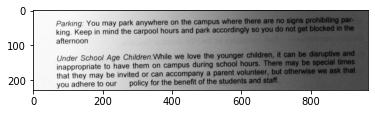

In [ ]:
## This Image was taken from NTU Learn
image_01 = image_loader(fol+"/assets/sample01.png")    
plt.imshow(image_01, cmap="gray")

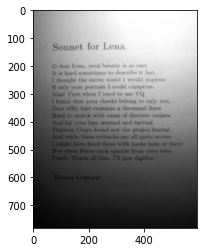

In [ ]:
## This Image was taken from NTU Learn
image_02 = image_loader(asset_fol + "/sample02.png")
plt.imshow(image_02, cmap="gray")

## **1. TASK 1**

 **Question
Implement the Ostu global thresholding algorithm for binarizing the sample text images and
feed the binairzed images to the OCR software to evaluate the OCR accuracy. Discuss any
problems with the Otsu global thresholding algorithm**

To complete this task we will be doing the following:
1. We first define our own function for Otsu thresholding  
2. We then utilize the PyTesseract for character recognition

### 1. Custom Otsu function

In [ ]:
def get_cosine_accuracy(prev, ocr):
  '''
        This function will check the OCR accuracy using cosine similarity
  '''
  try: 
    prev_tkn = word_tokenize(prev)  
    ocr_tkn = word_tokenize(ocr) 
    stop_words = stopwords.words('english')  
    prev_set = {w for w in prev_tkn if not w in stop_words}  
    ocr_set = {w for w in ocr_tkn if not w in stop_words} 
    ocr_list =[]     
    prev_list =[]
    uni = prev_set.union(ocr_set)  
    for w in uni: 
        if w in prev_set: prev_list.append(1) 
        else: prev_list.append(0) 
        if w in ocr_set: ocr_list.append(1)
        else: ocr_list.append(0) 
    this_c = 0
    for i in range(len(uni)): 
            this_c += prev_list[i] * ocr_list[i] 
    cosine_similarity = this_c / float((sum(prev_list)*sum(ocr_list))**0.5) 
    return cosine_similarity
  except:
    return float(0)

def get_histogram(img):
  '''
    Function used to plot the histogram
  '''
  hist, bins = np.histogram(img, 256, [0, 256])
  return hist, bins

def display_histogram(hist, bins):
  width = 0.7 * (bins[1] - bins[0])
  center = (bins[:-1] + bins[1:]) / 2
  plt.bar(center, hist, align='center', width=width)
  plt.show()

def count_pixels(histogram):
    '''
        Calculates the total number of pixels in the histogram
    '''
    total = 0
    for i in range(len(histogram)):
        total += histogram[i]
    return total

def get_pixel_prob(histogram, low, high, pixel_count):
  '''
        gets the total sum of pixel probabilities in that given range
  '''
  total = 0
  for r in range(low, high):
    total += histogram[r]/pixel_count
  return total

def get_pixel_mean(histogram, low, high, pixel_count, probs):
  '''
        returns the pixel mean value
  '''
  total = 0
  for r in range(low, high):
    total += (r * histogram[r] / pixel_count)
  total /= probs
  return total

def get_var(histogram, low, high, pixel_count, probs, mean):
  '''
        returns the variance
  '''
  total = 0
  for r in range(low, high):
    total += ((r - mean)**2) * (histogram[r] / pixel_count)
  total /= probs
  return total


def weighted_var(histogram, low, high, pixel_count):
  '''
        returns the weighted class variance
  '''
  q = get_pixel_prob(histogram, low, high, pixel_count)
  mean = get_pixel_mean(histogram, low, high, pixel_count, q)
  variance = get_var(histogram, low, high, pixel_count, q, mean)

  return (variance**2) * q

def opt_threshold(histogram):
  '''
        return the threshold value that minimzes intra-class variance
  '''
  pixel_count = count_pixels(histogram)
  optimal_threshold = 0
  lowest_variance = -1
  for threshold in range(1, 256):
    try:
      weighted_variance_L = weighted_var(histogram, 0, threshold, pixel_count)
      weighted_variance_R = weighted_var(histogram, threshold+1, 256, pixel_count)
      weighted_variance_total = weighted_variance_L + weighted_variance_R
    except:
      continue
    if lowest_variance == -1 or weighted_variance_total < lowest_variance:
      lowest_variance = weighted_variance_total
      optimal_threshold = threshold

  return optimal_threshold

def thresh_img(img, threshold):
  '''
        thresholds the inputted image
  '''
  img = (img > threshold) * 255
  return np.asarray(img, dtype=np.int32)

def otsu_threshold(img, show_hist=False):
  '''
        performs  Otsu thresholding on the inputted image
  '''
  hist, bins = get_histogram(img)
  threshold = opt_threshold(hist.tolist())
  if show_hist:
    display_histogram(hist, bins)
    print(f"Image threshold: {threshold}")
  output = np.zeros_like(img)
  output[:,:] = thresh_img(img, threshold)
  return output

def display_image(img):
  '''
        displays the image
  ''' 
  plt.imshow(img, cmap="gray")

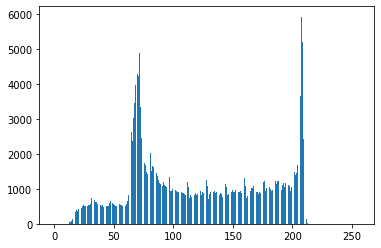

Image threshold: 127


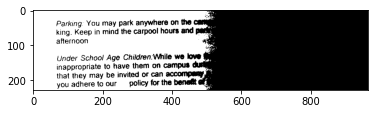

In [ ]:
otsu_img1 = otsu_threshold(image_01, True)
display_image(otsu_img1)

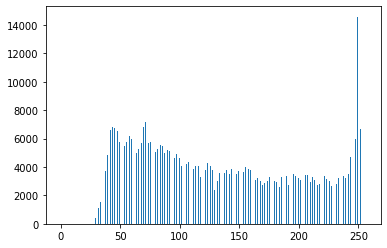

Image threshold: 143


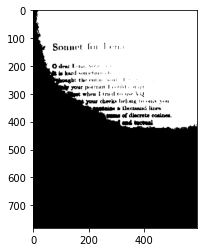

In [ ]:
otsu_img2 = otsu_threshold(image_02, True)
display_image(otsu_img2)

The poor binarization is because of the dark regions that skew the histogram


### ii. PyTesseract character recognition 

In [ ]:
prev_text_01 = "Parking: You may park anywhere on the campus where there are no signs prohibiting par- \n king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the afternoon \n\n Under School Age Children:While we love the younger children, it can be disruptive and \n inappropriate to have them on campus during school hours. There may be special times \n that they may be invited or can accompany a parent volunteer, but otherwise we ask \n that you adhere to our policy for the benefit of the students and staff."
prev_text_02 = "Sonnet for Lena\n O dear Lena, your beauty is so vast \n It is hard sometimes to describe it fast. I thought the entire world I would impress \n If only your portrait I could compress. \n Alas! First when I tried to use VQ \n I found that your cheeks belong to only you. \n Your silky hair contains a thousand lines \n Hard to match with sums of discrete cosines. \n And for your lips, sensual and tactual \n Thirteen Crays found not the perfect fractal. \n And while these setbacks are all quite severe \n I might have fixed them with hacks here or there \n But when filters took sparkle from your eyes \n I said, 'Damn all this. I'll just digitize.' \n Thomas Colthurst"

Here we do character recognition without Otsu thresholding for both the images found in NTU learn

In [ ]:
ocrtext_01 = pytesseract.image_to_string(image_01)
print(f"IMAGE 1:")
print(f"{ocrtext_01}")
print(f"Accuracy: {get_cosine_accuracy(prev_text_01, ocrtext_01)}")

IMAGE 1:
Parking: You may park anywhere on the ce
king. Keep in mind the carpool hours and park
afternoon

Under School Age Children:While we love
inappropriate to have them on campus @ )
that they may be invited or can accompany :
you adhere to our _ policy for the benefit of

 

Accuracy: 0.6998964726756152


In [ ]:
ocrtext_02 = pytesseract.image_to_string(image_02)
print(f"IMAGE 2:")
print(f"{prev_text_02}")
print(f"Accuracy: {get_cosine_accuracy(prev_text_02, ocrtext_02)}")

IMAGE 2:
Sonnet for Lena
 O dear Lena, your beauty is so vast 
 It is hard sometimes to describe it fast. I thought the entire world I would impress 
 If only your portrait I could compress. 
 Alas! First when I tried to use VQ 
 I found that your cheeks belong to only you. 
 Your silky hair contains a thousand lines 
 Hard to match with sums of discrete cosines. 
 And for your lips, sensual and tactual 
 Thirteen Crays found not the perfect fractal. 
 And while these setbacks are all quite severe 
 I might have fixed them with hacks here or there 
 But when filters took sparkle from your eyes 
 I said, 'Damn all this. I'll just digitize.' 
 Thomas Colthurst
Accuracy: 0.17025130615174972


Now we will do character recognition using the Otsu thresholding on both the images

   
     
  

Parking: You may park anywhere on the can
king. Keep in mind the carpool hours and p
afternoon

Under School Age Children:While we love §
inappropriate to have them on campus Gurm
that they may be invited or can accompany,

you adhere to our —_policy for the benefit

   
    

  

   

Accuracy: 0.6998964726756152


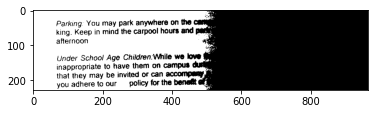

In [ ]:
otsu_image_01 = otsu_threshold(image_01)
display_image(otsu_image_01)

ocr_text_01 = pytesseract.image_to_string(otsu_image_01)
print(ocr_text_01)
print(f"Accuracy: {get_cosine_accuracy(prev_text_01, ocr_text_01)}")

Perna

 

Accuracy: 0.0


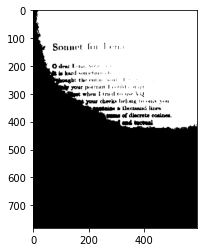

In [ ]:
plt.imshow(otsu_img2, cmap="gray")

ocr_text_02 = pytesseract.image_to_string(otsu_img2)
print(ocr_text_02)
print(f"Accuracy: {get_cosine_accuracy(prev_text_02, ocr_text_02)}")

## **2. TASK 2**

 **Question
Design your own algorithms to address the problem of Otsu global thresholding algorithm,
and evaluate OCR accuracy for the binary images as produced by your algorithms. You may
explore different approaches such as adaptive thresholding, image enhancement, etc., and
the target is to achieve the best OCR accuracy.**

To complete this task we will be doing the following techniques:
1. Adaptive thresholding
2. Background removal using variance  
3. Background removal using blurring 
4. Adaptive Gaussian thresholding



### 1. Adaptive thresholding

Parking: You may park anywhere on the campus where there are no signe prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under Schoo! Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our —_ policy for the benefit of the students and staff.

 

Accuracy: 0.9363821838346235


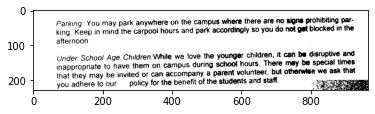

In [ ]:
def adaptive_thresholding(this_img, row_, col_):
  assert col_ <= this_img.shape[1] and row_ <= this_img.shape[0]
  res_ = np.zeros_like(this_img)
  for row in range(0, this_img.shape[0], row_):
    for col in range(0, this_img.shape[1], col_):
      row_start, row_end = row, min(this_img.shape[0], row+row_)
      col_start, col_end = col, min(this_img.shape[1], col+col_)
      block = this_img[row_start:row_end, col_start:col_end]
      otsu_block = otsu_threshold(block)
      res_[row_start:row_end, col_start:col_end] = otsu_block
  return res_
adaptive_image_01 = adaptive_thresholding(image_01, 100, 200)
display_image(adaptive_image_01)
adaptive_ocr_text_01 = pytesseract.image_to_string(adaptive_image_01)
print(adaptive_ocr_text_01)
print(f"Accuracy: {get_cosine_accuracy(prev_text_01, adaptive_ocr_text_01)}")

 

h, Aer Dena, come benuty in so rant itediaaitsdll
Ty ig bard sounetiznes to deseribe it inst. ala

Tthaght the entire world} eculd impress
Lf omly vour portrait [ crak] rompreee.
Atagl! Pieat when f tricct tt tse VQ
L fomod that your checks belkng to ouly you.
Pulr alike hal? contains a Mion thee

i Herd to match with muitos of discrete cosines |
Aud for your fips, sensual and factual
Thigtees Crays found wut ibe proper fractal
And stile then sefhacks are all quite 9st

.. A might have fixed thea: with hacks here or there ,

Bait when Aliem took spagkle from your eves

Dandd, ‘Demo all thie. I'l just digitize.” mad

 

 

Accuracy: 0.27612404178634276


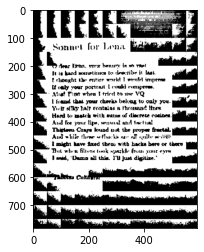

In [ ]:
adaptive_image_02 = adaptive_thresholding(image_02, 50, 50)
display_image(adaptive_image_02)
adaptive_ocr_text_02 = pytesseract.image_to_string(adaptive_image_02)
print(adaptive_ocr_text_02)
print(f"Accuracy: {get_cosine_accuracy(prev_text_02, adaptive_ocr_text_02)}")

### 2. Background removal using variance


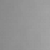

Variance: 50.5344


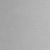

Variance: 48.64303616000001


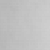

Variance: 36.31182016


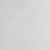

Variance: 22.42557184


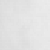

Variance: 15.058869760000002


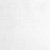

Variance: 23.67432896


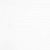

Variance: 1.7852160000000004


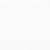

Variance: 0.9255801599999999


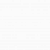

Variance: 0.9336422400000002


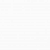

Variance: 0.999216


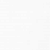

Variance: 0.9072486399999999


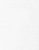

Variance: 3.6190674556213027


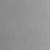

Variance: 48.37453056000001


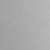

Variance: 44.84369600000001


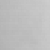

Variance: 31.162472959999995


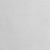

Variance: 21.38494976


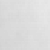

Variance: 21.161095039999996


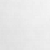

Variance: 23.81241536


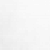

Variance: 13.781669760000002


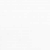

Variance: 1.40988096


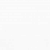

Variance: 0.9095545600000001


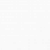

Variance: 0.6720838400000001


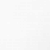

Variance: 3.2376953600000005


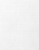

Variance: 9.040264036817883


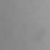

Variance: 43.966220160000006


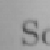

Variance: 282.3872070400001


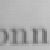

Variance: 467.23806399999995


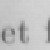

Variance: 497.4836294399999


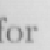

Variance: 479.6256


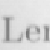

Variance: 569.01105856


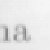

Variance: 373.20175104


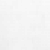

Variance: 5.38048704


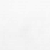

Variance: 5.99260416


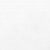

Variance: 4.830040959999999


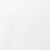

Variance: 13.30916544


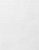

Variance: 10.820112031558185


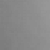

Variance: 40.85648064


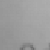

Variance: 78.4016


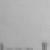

Variance: 120.43587264


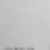

Variance: 68.57135296


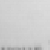

Variance: 111.11161600000001


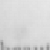

Variance: 179.82316736


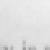

Variance: 116.73204416


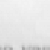

Variance: 143.11083776000004


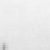

Variance: 56.353778559999995


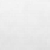

Variance: 28.02857664


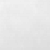

Variance: 23.94275584


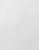

Variance: 24.383957922419466


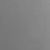

Variance: 41.90865599999999


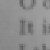

Variance: 143.727296


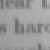

Variance: 277.89886976


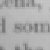

Variance: 311.20849599999997


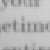

Variance: 347.55533504


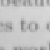

Variance: 296.28393664


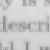

Variance: 328.03896576000005


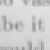

Variance: 298.12789504


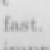

Variance: 234.14302400000003


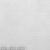

Variance: 64.738864


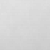

Variance: 29.28890624


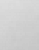

Variance: 32.162761341222875


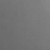

Variance: 36.94912256


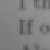

Variance: 134.92252416


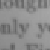

Variance: 229.83609344


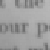

Variance: 283.64953856


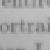

Variance: 284.24613056


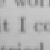

Variance: 307.88822016


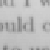

Variance: 310.79493824


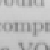

Variance: 346.36265664


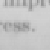

Variance: 193.07770624000003


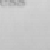

Variance: 54.570661759999986


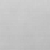

Variance: 28.707503999999993


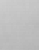

Variance: 31.13382879684418


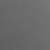

Variance: 23.33713664


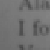

Variance: 105.20915135999999


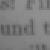

Variance: 176.15758015999998


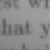

Variance: 225.62113536


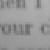

Variance: 227.77478336000001


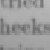

Variance: 314.46374656


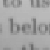

Variance: 303.20697535999994


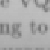

Variance: 297.26595584


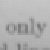

Variance: 290.29489856000004


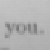

Variance: 202.74886336


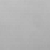

Variance: 29.85502976


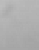

Variance: 33.60900880999342


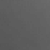

Variance: 17.257776


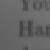

Variance: 101.78193600000002


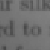

Variance: 135.19611584


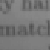

Variance: 148.78981824000002


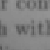

Variance: 184.62403776000002


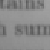

Variance: 218.82996224000001


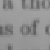

Variance: 259.06809856


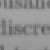

Variance: 273.29074176


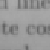

Variance: 222.12997823999999


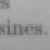

Variance: 250.11302400000002


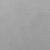

Variance: 30.402520959999993


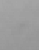

Variance: 20.52680710059171


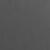

Variance: 14.788695040000004


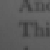

Variance: 72.84883136


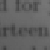

Variance: 122.45393599999998


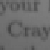

Variance: 118.90801343999999


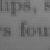

Variance: 141.76655616000002


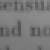

Variance: 183.96857024000002


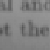

Variance: 186.49224895999998


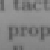

Variance: 231.32589824000001


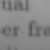

Variance: 205.83163136


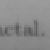

Variance: 197.77812736


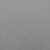

Variance: 45.66850816


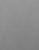

Variance: 50.545084549638396


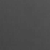

Variance: 13.52909504


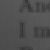

Variance: 52.73311424


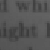

Variance: 88.158256


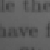

Variance: 94.61254656


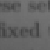

Variance: 112.1452


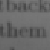

Variance: 134.13633536


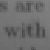

Variance: 144.96047296000003


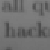

Variance: 151.590576


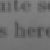

Variance: 132.12985600000002


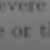

Variance: 107.10229504


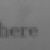

Variance: 116.61228736000001


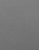

Variance: 26.383375147928994


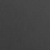

Variance: 11.85566464


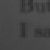

Variance: 39.44584896


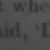

Variance: 62.26105536


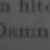

Variance: 83.97251776


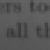

Variance: 83.27132864


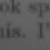

Variance: 89.75567615999998


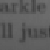

Variance: 111.97392384000001


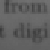

Variance: 116.60071424


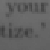

Variance: 96.05490944


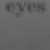

Variance: 45.03438016


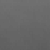

Variance: 25.167904640000003


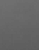

Variance: 23.199604470742933


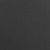

Variance: 10.16950464


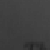

Variance: 29.920266240000004


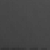

Variance: 21.748800000000003


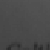

Variance: 44.45908224


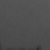

Variance: 27.76741376


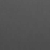

Variance: 20.056434559999996


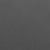

Variance: 20.68117696


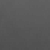

Variance: 23.704839039999996


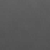

Variance: 19.669152639999997


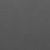

Variance: 18.36522496


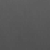

Variance: 20.137453439999998


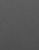

Variance: 19.25918316896778


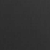

Variance: 10.005296


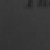

Variance: 12.017344


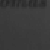

Variance: 20.07322304


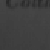

Variance: 18.769344000000004


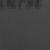

Variance: 25.11472896


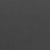

Variance: 7.938816


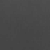

Variance: 8.528570239999999


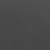

Variance: 10.12363456


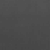

Variance: 13.12669376


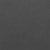

Variance: 11.62937024


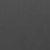

Variance: 10.72592384


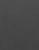

Variance: 12.156824194608806


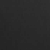

Variance: 7.18665216


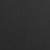

Variance: 11.530664960000001


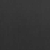

Variance: 12.422525440000001


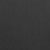

Variance: 11.851168640000001


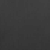

Variance: 11.06106624


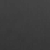

Variance: 16.564736


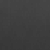

Variance: 15.122442239999998


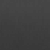

Variance: 19.362624


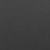

Variance: 18.540223360000002


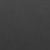

Variance: 20.257546240000003


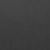

Variance: 18.89563136


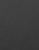

Variance: 14.226867587113741


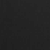

Variance: 3.8116761599999998


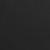

Variance: 5.60175296


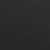

Variance: 7.80729024


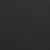

Variance: 8.12321024


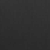

Variance: 9.91886016


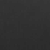

Variance: 8.656754560000001


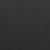

Variance: 12.732976


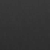

Variance: 13.0444


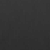

Variance: 10.139987839999998


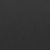

Variance: 9.702335360000001


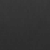

Variance: 12.53372096


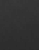

Variance: 10.84122130177515


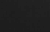

Variance: 2.2223734375000004


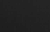

Variance: 3.5826937500000002


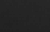

Variance: 2.7401109375


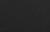

Variance: 3.1191937500000004


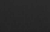

Variance: 4.04174375


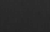

Variance: 3.5701734375000003


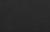

Variance: 3.9712437499999993


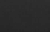

Variance: 3.7735999999999996


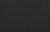

Variance: 4.3851234375


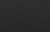

Variance: 4.534960937500001


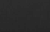

Variance: 3.6893109375000006


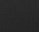

Variance: 3.825256307527943
ynnel for Lena

 

h Aer Dena, come benuty in so rant
Hy ie bard soineti:nes to deecribe it Laat.
Tthaght the entire world} eculd impress
Lf omly vour portrait [ crak] rompreee.
Atagl! Pieat when f tricct tt tse VQ
L fomod that your checks belkng to ouly you.
Pulr alike hal? contains a Mion thee
Hard to match with mums of discrete cosines.
Aud for your fips, sensual and factual
Thigtees Crays found wut ibe proper fractal «
And stile fhene sefhackc are all qaike ice
i might have fixed thea: with hacks here or there
6 when filiem took sparkle frou: your

wd, ‘Demo all this. I'l) just digitize.”

Accuracy: 0.31549666086411104


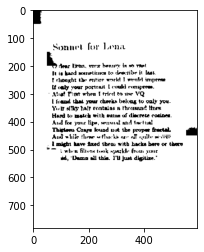

In [ ]:
def adaptive_otsu_bg_removal(this_img, row_, col_, detect_bg=False, background_threshold=50):
  assert col_ <= this_img.shape[1] and row_ <= this_img.shape[0]
  res = np.zeros_like(this_img)
  for row in range(0, this_img.shape[0], row_):
    for col in range(0, this_img.shape[1], col_):
      row_start, row_end = row, min(this_img.shape[0], row+row_)
      col_start, col_end = col, min(this_img.shape[1], col+col_)
      block = this_img[row_start:row_end, col_start:col_end]
      otsu_block = otsu_threshold(block)
      if detect_bg:
        var = np.var(block)
        cv2_imshow(block)
        print(f"Variance: {var}")
        if var < background_threshold:
          otsu_block.fill(255)
      res[row_start:row_end, col_start:col_end] = otsu_block
  return res

with_background_adaptive_otsu_image_02 = adaptive_otsu_bg_removal(image_02, 50, 50, True)
display_image(with_background_adaptive_otsu_image_02)

ocr_adaptive_otsu_text_2_with_bg = pytesseract.image_to_string(with_background_adaptive_otsu_image_02)
print(ocr_adaptive_otsu_text_2_with_bg)
print(f"Accuracy: {get_cosine_accuracy(prev_text_02, ocr_adaptive_otsu_text_2_with_bg)}")

### 3. Background removal using blurring

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly $0 you do not get blocked in the
afternoon

Under Schoo! Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during schoo! hours. There may be special times
that they may be invited or can accompany 4 parent volunteer, but otherwise we oak that
you adhere to our —_policy for the benefit of the students and staff.

 

Accuracy: 0.8757605390397141


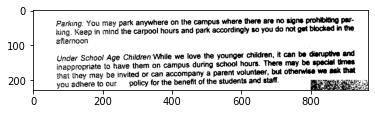

In [ ]:
def removeBackground(this_img, kernel_size=5):
  blurred_image = cv2.GaussianBlur(this_img,(kernel_size,kernel_size),0)
  image_without_background = blurred_image - this_img
  return image_without_background
image_01_without_background = removeBackground(image_01, 1001)
image_01_removed_background = adaptive_thresholding(image_01_without_background, 100, 200)
display_image(image_01_removed_background)
ocr_removed_the_background_text_01 = pytesseract.image_to_string(image_01_removed_background)
print(ocr_removed_the_background_text_01)
print(f"Accuracy: {get_cosine_accuracy(prev_text_01, ocr_removed_the_background_text_01)}")

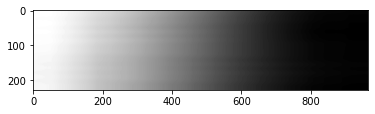

In [ ]:
display_image(cv2.GaussianBlur(image_01,(1001,1001),0))

 

O deer Lena, vour fesuty in ao vent

Te ia bard sanelinnes ta clescribe it baat,
Pthought the entire work! } wand impress
Hf only your portrait [euuhd comprenn.

Alas! Fire when I cciedt to nee VQ

[ fowod that your cheeks belong to only you.
Your silky bar coptainn @ thoussod lines
Hard to match with sume of discrete cosines.
And for your lips, setewal aid tactuad
Thirtern Crays found not the proper fractal,
And while thee setbacks arr all quile severe
I might have fixed them with hacks here or thers
Bet when filtem Look sparkle from your eyes
Deaid, ‘Doma all thie. I'll just digitive.”

 

Accuracy: 0.44416506919798654


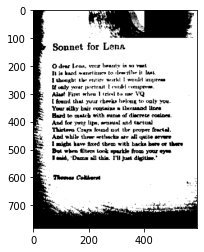

In [ ]:
image_02_without_background = removeBackground(image_02, 801)
image_02_removed_background = adaptive_thresholding(image_02_without_background, 100, 200)
display_image(image_02_removed_background)
ocr_removed_the_background_text_02 = pytesseract.image_to_string(image_02_removed_background)
print(ocr_removed_the_background_text_02)
print(f"Accuracy: {get_cosine_accuracy(prev_text_02, ocr_removed_the_background_text_02)}")

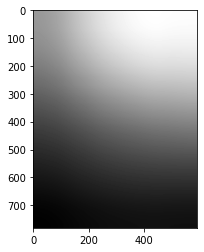

In [ ]:
display_image(cv2.GaussianBlur(image_02,(801,801),0))

### 4. Adaptive Gaussian Thresholding

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under School Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our policy for the benefit of the students and staff.

Accuracy: 1.0


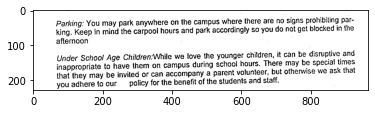

In [ ]:
def adaptiveGaussianThreshholding(this_image, blkSize, C):
  thresholded_result = cv2.adaptiveThreshold(this_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blkSize, C)
  return thresholded_result
adap_gaus_image_01 = adaptiveGaussianThreshholding(image_01, 13, 9)
display_image(adap_gaus_image_01)
ocrAdaptive_gaus_text01 = pytesseract.image_to_string(adap_gaus_image_01)
print(ocrAdaptive_gaus_text01)
print(f"Accuracy: {get_cosine_accuracy(prev_text_01, ocrAdaptive_gaus_text01)}")

« Sonnet for Lena , °

O dear Lena, your benuty Ja oa vant

It is hard eometi:nes to deacribe It fast. |

L thought Lhe entire world [ would impress.

Lf onty your portrait [ could compress.

Alas! First when I tried to use VQ

L found that your checks belong to only you.
Your silky bait containa a thousand lines
Hard to match with sums of discrete cosines.
And for your lips, senrual and tactual

Thirteen Craya found not the proper fractal,
And while these setbacks are all quite severe
IT ohight bave fixed them with hacks bere or there
But when filters Look sprrkle from your eyes
Jeni, ‘Damo all thin. I'll Just digitize.”

Thomas Caltharst

Accuracy: 0.6490770196350103


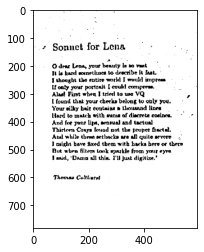

In [ ]:
adap_gaus_image_02 = adaptiveGaussianThreshholding(image_02, 37, 4)
display_image(adap_gaus_image_02)
ocrAdaptive_gaus_text02 = pytesseract.image_to_string(adap_gaus_image_02)
print(ocrAdaptive_gaus_text02)
print(f"Accuracy: {get_cosine_accuracy(prev_text_02, ocrAdaptive_gaus_text02)}")

## **3. TASK 3 (Optional)**

 **Question
Discuss how to improve recognition algorithms for more robust and accurate character
recognition while document images suffer from different types of image degradation. This is
an open and optional task. There will be bonus points if you have good ideas on it.**

To complete this task we will be doing the following pre-processing steps:
1. Perspective Transform
2. Skew Correction  
3. Binarization
4. Speckle Noise Removal
5. Thinning

### 3.1 Perspective transform



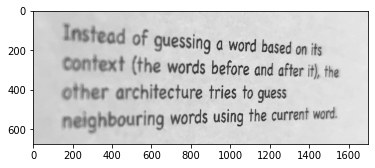

In [ ]:
neural_image_01 = image_loader(asset_fol + "/neural_text_03.jpeg")
# prev_neural_text_01 = "Our Neural Network\n Let's finally draw a diagram of our long-awaited neural nets. It should look something\n like this:"
prev_neural_text_01 = "Instead of guessing a word based on its\ncontext (the words before and after it), the\nother architecture tries to guess\nneighbouring words using the current word."

display_image(neural_image_01)

Original text:
Instead of guessing a word based on its
context (the words before and after it), the
other architecture tries to guess
neighbouring words using the current word.

Output text:
lstead of of guessing « a word base toni
text (the words before and after it), the & E
other architecture tries to guess

| neighbour ing words using the current word.

   
  
 
 
   

Accuracy: 0.6396021490668313


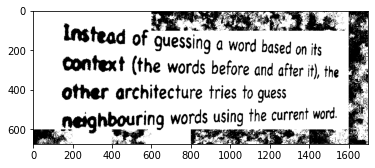

In [ ]:
adaptive_otsu_neural_01 = adaptive_thresholding(neural_image_01, 100, 200)
display_image(adaptive_otsu_neural_01)
adap_gaus_neural_01 = pytesseract.image_to_string(adaptive_otsu_neural_01)
print(f"Original text:")
print(prev_neural_text_01)
print() 
print(f"Output text:")
print(adap_gaus_neural_01)
print(f"Accuracy: {get_cosine_accuracy(prev_neural_text_01, adap_gaus_neural_01)}")

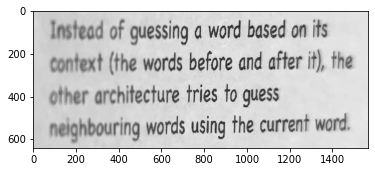

In [ ]:
def perspectiveTransform(this_image, edge_):
    '''
        This function performs perspective Transform and return the new image that has been transformed
    '''
    (tl, tr, br, bl) = edge_
    width_top = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    width_bottom = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2)) 
    width = max(int(width_top), int(width_bottom)) 
    height_left = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2)) 
    height_right = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2)) 
    height = max(int(height_right), int(height_left))
    new_edge = np.array([[0, 0],[width - 1, 0],[width - 1, height - 1],[0, height - 1]], dtype = "float32")
    new_matx = cv2.getPerspectiveTransform(edge_, new_edge)
    new_image = cv2.warpPerspective(this_image, new_matx, (width, height))
    return new_image

# neural_edges = np.asarray([(50, 10), (1810, 180), (1810, 400), (50, 350)], dtype = "float32")
## (LW) (RW) (RB) (LB)
neural_edges = np.asarray([(40, 10), (1600, 150), (1600, 600), (40, 650)], dtype = "float32")
new_neural_image_01 = perspectiveTransform(neural_image_01, neural_edges)
display_image(new_neural_image_01)

Original text:
Instead of guessing a word based on its
context (the words before and after it), the
other architecture tries to guess
neighbouring words using the current word.

Output text:
 

Instead of quessing a word based on its li”
context (the words before and after It) *
other architecture tries fo guess a
neighbouring words using Th the current vr

 

 

Accuracy: 0.7092081432669752


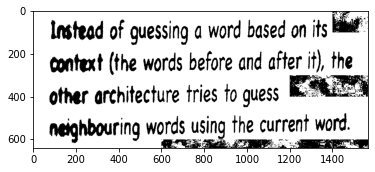

In [ ]:
new_adaptive_otsu_neural_01 = adaptive_thresholding(new_neural_image_01, 100, 200)
display_image(new_adaptive_otsu_neural_01)
new_adap_gaus_neural_01 = pytesseract.image_to_string(new_adaptive_otsu_neural_01)
print(f"Original text:")
print(prev_neural_text_01)
print()
print(f"Output text:")
print(new_adap_gaus_neural_01)
print(f"Accuracy: {get_cosine_accuracy(prev_neural_text_01, new_adap_gaus_neural_01)}")

### 3.2 Image de-skewing



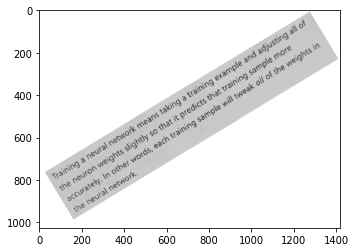

In [ ]:
#Loading a 2D-skewed image
slant_img = image_loader(asset_fol + "/slant_01.png")
prev_slant_text = "Training a neural network means taking a training example and adjusting all of\nthe neuron weights slighly so that it predicts that training sample more\naccurately. In other words, each training sample will tweak all of the weights in\nthe neural network."
display_image(slant_img)

Original text:
Training a neural network means taking a training example and adjusting all of
the neuron weights slighly so that it predicts that training sample more
accurately. In other words, each training sample will tweak all of the weights in
the neural network.

Output text:

Accuracy: 0.0


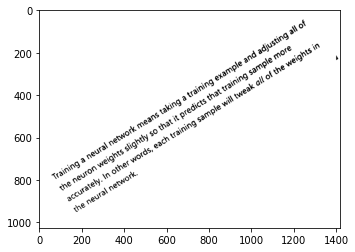

In [ ]:
# Conducting thresholding and OCR on image
adaptive_otsu_slant_img = adaptive_thresholding(slant_img, 1000, 1400)
display_image(adaptive_otsu_slant_img)

ocr_adaptive_otsu_slant_img = pytesseract.image_to_string(adaptive_otsu_slant_img)
print(f"Original text:")
print(prev_slant_text)
print()
print(f"Output text:")
print(ocr_adaptive_otsu_slant_img)
print(f"Accuracy: {get_cosine_accuracy(prev_slant_text, ocr_adaptive_otsu_slant_img)}")

In [ ]:
def get_slant_angle(cimg):
    img_copy = cimg.copy()
    blur = cv2.GaussianBlur(img_copy, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

def rotate_image(cimg, angle: float): 
    '''
        This function rotates the image around its center point
    ''' 
    img_copy = cimg.copy()
    (h, w) = img_copy.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    img_copy = cv2.warpAffine(img_copy, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return img_copy

def make_straight(cimg):
    angle = get_slant_angle(cimg)
    return rotate_image(cimg, -1.0 * angle)    

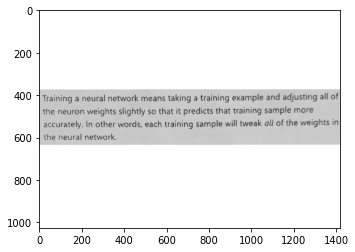

In [ ]:
straight_img = make_straight(slant_img)
display_image(straight_img)

Original text:
Training a neural network means taking a training example and adjusting all of
the neuron weights slighly so that it predicts that training sample more
accurately. In other words, each training sample will tweak all of the weights in
the neural network.

Output text:
Training a neural network means taking a training example and adjusting all o
the neuron weights slightly so that it predicts that training sample more
accurately. In other words, each training sample will tweak ail of the weights i
the neural network.

Accuracy: 0.9233805168766388


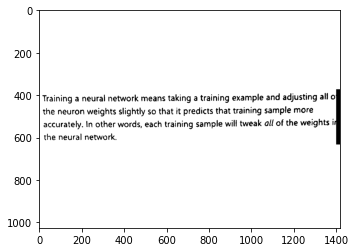

In [ ]:
adaptive_otsu_straight_img = adaptive_thresholding(straight_img, 1000, 1400)
display_image(adaptive_otsu_straight_img)

ocr_adaptive_otsu_straight_img = pytesseract.image_to_string(adaptive_otsu_straight_img)
print(f"Original text:")
print(prev_slant_text)
print()
print(f"Output text:")
print(ocr_adaptive_otsu_straight_img)
print(f"Accuracy: {get_cosine_accuracy(prev_slant_text, ocr_adaptive_otsu_straight_img)}")

### 3.4 Removing Speckle Noise



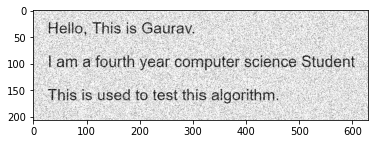

In [165]:
noise_image = image_loader(asset_fol + "/noise_image.png")
prev_text_noise = "Hello, This is Gaurav.\nI am a fourth year computer science Student\nThis is used to test this algorithm."
display_image(noise_image)

Original text:
Hello, This is Gaurav.
I am a fourth year computer science Student
This is used to test this algorithm.

Output text:
Hello, This is Gaurav.

ot am a fourth-year computer scierice

 

This is used to'tést this algotithm.

    

Accuracy: 0.5400617248673216


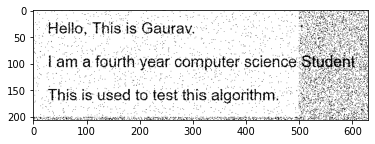

In [166]:
adaptive_otsu_noise_image = adaptive_thresholding(noise_image, 200, 250)
display_image(adaptive_otsu_noise_image)

ocr_adaptive_otsu_noise_image = pytesseract.image_to_string(adaptive_otsu_noise_image)
print(f"Original text:")
print(prev_text_noise)
print()
print(f"Output text:")
print(ocr_adaptive_otsu_noise_image)
print(f"Accuracy: {get_cosine_accuracy(prev_text_noise, ocr_adaptive_otsu_noise_image)}")

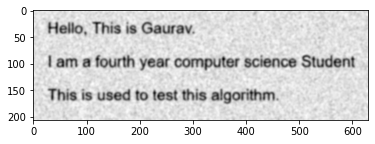

In [167]:
gaussian_noise_image = cv2.GaussianBlur(noise_image, (9, 9), 0)
display_image(gaussian_noise_image) 
plt.show()

Original text:
Hello, This is Gaurav.
I am a fourth year computer science Student
This is used to test this algorithm.

Output text:
Hello, This is Gaurav.
lam a fourth year computer science Student
This is used to test this is algorthm.

Accuracy: 0.8571428571428571


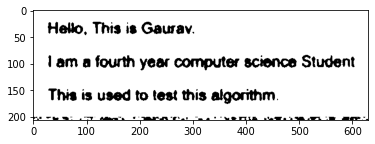

In [168]:
adaptive_otsu_gaussian = adaptive_thresholding(gaussian_noise_image, 200, 250)
display_image(adaptive_otsu_gaussian)
ocr_adaptive_otsu_gaussian = pytesseract.image_to_string(adaptive_otsu_gaussian)
print(f"Original text:")
print(prev_text_noise)
print()
print(f"Output text:")
print(ocr_adaptive_otsu_gaussian)
print(f"Accuracy: {get_cosine_accuracy(prev_text_noise, ocr_adaptive_otsu_gaussian)}")

### 3.5 Thinning 

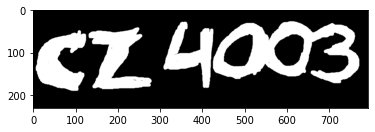

In [186]:
thick_text = image_loader(asset_fol + "/cz40032.png")
prev_thick_text = "CZ 4003"

# thick_text = image_loader(asset_fol + "/thick_text.png")
# prev_thick_text = "COMPUTER\nVISSION"

plt.imshow(thick_text, cmap="gray")

Original text:
CZ 4003

Output text:
CZ 4O03

Accuracy: 0.5


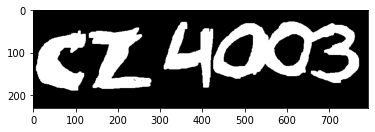

In [187]:
adaptive_otsu_thin_text = adaptive_thresholding(thick_text, 50, 50)
display_image(adaptive_otsu_thin_text)
ocr_adaptive_otsu_thin_text = pytesseract.image_to_string(adaptive_otsu_thin_text)
print(f"Original text:")
print(prev_thick_text)
print()
print(f"Output text:")
print(ocr_adaptive_otsu_thin_text)
print(f"Accuracy: {get_cosine_accuracy(prev_thick_text, ocr_adaptive_otsu_thin_text)}")

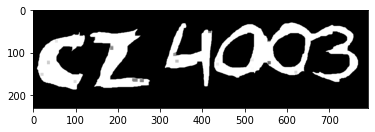

In [188]:
kernel = np.ones((7,7),np.uint8)
thinned_thick_text = cv2.erode(thick_text, kernel,iterations = 1)
display_image(thinned_thick_text)

Original text:
CZ 4003

Output text:
CZ 4003

Accuracy: 1.0


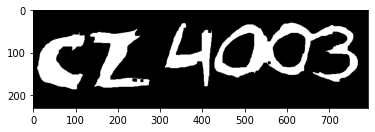

In [189]:
adaptive_otsu_thinned_thick_text = adaptive_thresholding(thinned_thick_text, 50, 50)
display_image(adaptive_otsu_thinned_thick_text)
ocr_adaptive_otsu_thinned_thick_text = pytesseract.image_to_string(adaptive_otsu_thinned_thick_text)
print(f"Original text:")
print(prev_thick_text)
print()
print(f"Output text:")
print(ocr_adaptive_otsu_thinned_thick_text)
print(f"Accuracy: {get_cosine_accuracy(prev_thick_text, ocr_adaptive_otsu_thinned_thick_text)}")